<a href="https://colab.research.google.com/github/gibsonx/CE888/blob/master/Assignment/sentiment_analysis_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U tensorflow tensorflow_datasets tensorflow_text zhon bert-for-tf2 sentencepiece
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!git clone https://github.com/cardiffnlp/tweeteval.git

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.4.1)
     |████████████████████████████████| 3.7MB 10.0MB/s 
     |████████████████████████████████| 3.4MB 58.9MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 1.2MB 49.1MB/s 
  Created wheel for zhon: filename=zhon-1.1.5-cp36-none-any.whl size=84293 sha256=8e6b4d46897d793de04967066a4f04def5039bf40df0c11b452efb22b5072b2a
  Stored in directory: /root/.cache/pip/wheels/0e/93/5a/ad2f403c359ba996e33c21bf18611d921413df9740ede2fcf4
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp36-none-any.whl size=30534 sha256=c68d677c3d0303b9cbf200cdb06f528cf6615c1ae75ffcc1a94cf5e87eebf227
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp36-none-any.whl size=7912 sha256=a53fa920fe91

In [3]:
from google.colab import output
from google.colab import drive

import bert
import collections
import pathlib
import re
import string
import os
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import WordNetLemmatizer

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text
from tensorflow.keras import Input, layers, losses, preprocessing, utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from zhon import hanzi 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import csv
import tokenization

try:
    %tensorflow_version 2.x
except Exception:
    pass
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))    

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Num GPUs Available:  1


In [10]:
# drive.mount('/content/drive/')
base_dir = '/content/tweeteval/datasets/'
hate_dir = base_dir + "hate"
irony_dir = base_dir + "irony"
offensive_dir = base_dir + "offensive"


In [9]:
stop_words = stopwords.words('english')
new_words=['im']
for i in new_words:
  stop_words.append(i) 

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', string)

def preprocess_tweet_text(tweet):
    tweet = tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = tweet.translate(str.maketrans('', '', hanzi.punctuation))
    tweet = remove_emoji(tweet)
    tweet_tokens = word_tokenize(tweet)
    # Remove stopwords
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    return " ".join(filtered_words)

def readfile(text):
  pd_list = []
  with open(text,'r') as f:
    for tweet in f.read().splitlines():
      tweet = preprocess_tweet_text(tweet)
      pd_list.append(tweet)   
  return pd_list

def readfile_label(text):
  pd_list = []
  with open(text,'r') as f:
    for tweet in f.read().splitlines():
      pd_list.append(int(tweet))  
  return pd_list


In [17]:
#Hate DataFrame
hate_dict_train = {'text': readfile(os.path.join(hate_dir,"train_text.txt")),
    'label': readfile_label(os.path.join(hate_dir,"train_labels.txt"))}
hate_dict_val = {'text': readfile(os.path.join(hate_dir,"val_text.txt")),
    'label': readfile_label(os.path.join(hate_dir,"val_labels.txt"))}
hate_dict_test = {'text': readfile(os.path.join(hate_dir,"test_text.txt")),
    'label': readfile_label(os.path.join(hate_dir,"test_labels.txt"))}

   
df_hate_train = pd.DataFrame(hate_dict_train)
df_hate_val = pd.DataFrame(hate_dict_train)
df_hate_test = pd.DataFrame(hate_dict_test)



hate_frames = [df_hate_train, df_hate_val, df_hate_test]
df_hate = pd.concat(hate_frames)
not_hate = df_hate[df_hate['label'] == 0]
hate = df_hate[df_hate['label'] == 1]

not_hate_text = " ".join(preprocess_tweet_text(review) for review in not_hate["text"])
hate_text = " ".join(preprocess_tweet_text(review) for review in hate["text"])

#Irony DataFrame
irony_dict_train = {'text': readfile(os.path.join(irony_dir,"train_text.txt")),
    'label': readfile_label(os.path.join(irony_dir,"train_labels.txt"))}
irony_dict_val = {'text': readfile(os.path.join(irony_dir,"val_text.txt")),
    'label': readfile_label(os.path.join(irony_dir,"val_labels.txt"))}
irony_dict_test = {'text': readfile(os.path.join(irony_dir,"test_text.txt")),
    'label': readfile_label(os.path.join(irony_dir,"test_labels.txt"))}

df_irony_train = pd.DataFrame(irony_dict_train)
df_irony_val = pd.DataFrame(irony_dict_val)
df_irony_test = pd.DataFrame(irony_dict_test)

irony_frames = [df_irony_train, df_irony_val, df_irony_test]
df_irony = pd.concat(irony_frames)
not_irony  = df_irony[df_irony['label'] == 0]
irony  = df_irony[df_irony['label'] == 1]

not_irony_text = " ".join(preprocess_tweet_text(review) for review in not_irony["text"])
irony_text = " ".join(preprocess_tweet_text(review) for review in irony["text"])

#Offensive DataFrame
offensive_dict_train = {'text': readfile(os.path.join(offensive_dir,"train_text.txt")),
    'label': readfile_label(os.path.join(offensive_dir,"train_labels.txt"))}
offensive_dict_val = {'text': readfile(os.path.join(offensive_dir,"val_text.txt")),
    'label': readfile_label(os.path.join(offensive_dir,"val_labels.txt"))}
offensive_dict_test = {'text': readfile(os.path.join(offensive_dir,"test_text.txt")),
    'label': readfile_label(os.path.join(offensive_dir,"test_labels.txt"))}

df_offensive_train = pd.DataFrame(offensive_dict_train)
df_offensive_val = pd.DataFrame(offensive_dict_val)
df_offensive_test = pd.DataFrame(offensive_dict_test)

offensive_frames = [df_offensive_train, df_offensive_val, df_offensive_test]
df_offensive = pd.concat(offensive_frames)
not_offensive  = df_offensive[df_offensive['label'] == 0]
offensive  = df_offensive[df_offensive['label'] == 1]

not_offensive_text = " ".join(preprocess_tweet_text(review) for review in not_offensive["text"])
offensive_text = " ".join(preprocess_tweet_text(review) for review in offensive["text"])



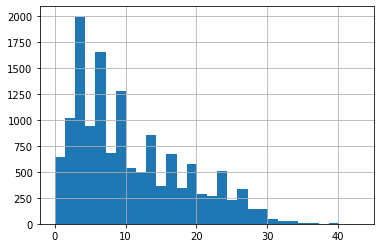

In [38]:
#The length of sentences after tokenization
seq_len = [len(i.split()) for i in df_offensive['text']]
pd.Series(seq_len).hist(bins = 30)

Stored variables and their in-db values:


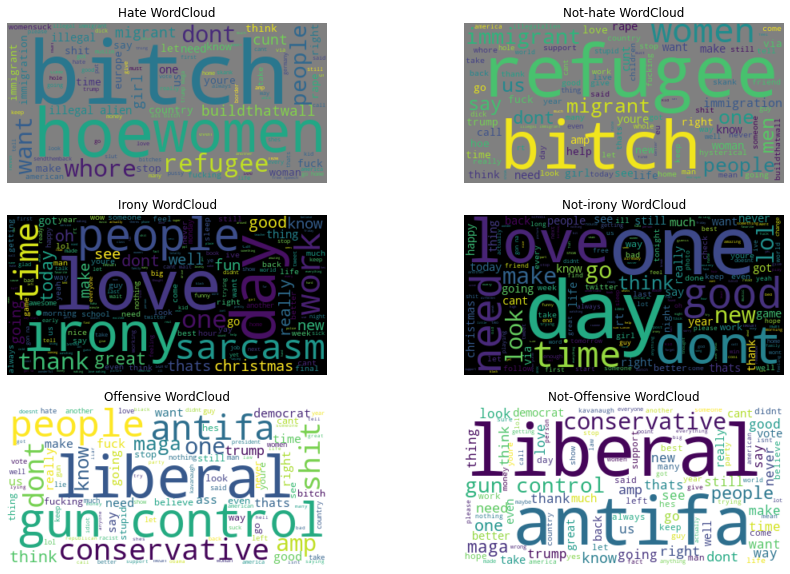

In [ ]:
%store
wordcloud_not_hate = WordCloud(max_words=100,background_color="grey").generate(not_hate_text)
wordcloud_hate = WordCloud(max_words=100,background_color="grey").generate(hate_text)

wordcloud_not_irony = WordCloud().generate(not_irony_text)
wordcloud_irony = WordCloud().generate(irony_text)

wordcloud_not_offensive = WordCloud(max_words=100,background_color="white").generate(not_offensive_text)
wordcloud_offensive = WordCloud(max_words=100,background_color="white").generate(offensive_text)

fig, axs = plt.subplots(3,2)
fig.set_figheight(10)
fig.set_figwidth(15)
axs[0,0].axis('off')
axs[0,0].set_title("Hate WordCloud")
axs[0,0].imshow(wordcloud_hate, interpolation='bilinear')
axs[0,1].set_title("Not-hate WordCloud")
axs[0,1].imshow(wordcloud_not_hate, interpolation='bilinear')
axs[0,1].axis('off')
axs[1,0].set_title("Irony WordCloud")
axs[1,0].imshow(wordcloud_irony, interpolation='bilinear')
axs[1,0].axis('off')
axs[1,1].set_title("Not-irony WordCloud")
axs[1,1].imshow(wordcloud_not_irony, interpolation='bilinear')
axs[1,1].axis('off')
axs[2,0].set_title("Offensive WordCloud")
axs[2,0].imshow(wordcloud_offensive, interpolation='bilinear')
axs[2,0].axis('off')
axs[2,1].set_title("Not-Offensive WordCloud")
axs[2,1].imshow(wordcloud_not_offensive, interpolation='bilinear')
axs[2,1].axis('off')

plt.show()
plt.close()

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
  all_tokens = []
  all_masks = []
  all_segments = []

  for text in texts:
      text = tokenizer.tokenize(text)
          
      text = text[:max_len-2]
      input_sequence = ["[CLS]"] + text + ["[SEP]"]
      pad_len = max_len - len(input_sequence)
      
      tokens = tokenizer.convert_tokens_to_ids(input_sequence)
      tokens += [0] * pad_len
      pad_masks = [1] * len(input_sequence) + [0] * pad_len
      segment_ids = [0] * max_len
      

      all_tokens.append(tokens)
      all_masks.append(pad_masks)
      all_segments.append(segment_ids)

  return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
#Create Bert Model
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 20.9 s, sys: 4.05 s, total: 24.9 s
Wall time: 29.6 s


In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_hate.text, df_hate.label, test_size=0.2, random_state=50)

In [ ]:
train_input = bert_encode(X_train, tokenizer, max_len=160)
test_input = bert_encode(X_test, tokenizer, max_len=160)

In [ ]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
train_history = model.fit(
    train_input, y_train,
    validation_split=0.2,
    epochs=10,
    callbacks=[checkpoint],
    batch_size=16
)

Epoch 1/10
839/839 [==============================] - 1529s 2s/step - loss: 0.5483 - accuracy: 0.7080 - val_loss: 0.4084 - val_accuracy: 0.8173
Epoch 2/10
839/839 [==============================] - 1492s 2s/step - loss: 0.2782 - accuracy: 0.8772 - val_loss: 0.5511 - val_accuracy: 0.7086
Epoch 3/10
839/839 [==============================] - 1491s 2s/step - loss: 0.4020 - accuracy: 0.8070 - val_loss: 0.3510 - val_accuracy: 0.8692
Epoch 4/10
839/839 [==============================] - 1492s 2s/step - loss: 0.0829 - accuracy: 0.9724 - val_loss: 0.3367 - val_accuracy: 0.8865
Epoch 5/10
839/839 [==============================] - 1492s 2s/step - loss: 0.0342 - accuracy: 0.9888 - val_loss: 0.4642 - val_accuracy: 0.8832
Epoch 6/10
839/839 [==============================] - 1490s 2s/step - loss: 0.0297 - accuracy: 0.9906 - val_loss: 0.5409 - val_accuracy: 0.8796
Epoch 7/10
839/839 [==============================] - 1491s 2s/step - loss: 0.0227 - accuracy: 0.9905 - val_loss: 0.5001 - val_accuracy:

In [ ]:
train_history.history

{'accuracy': [0.7585693001747131,
  0.7923994064331055,
  0.8675857186317444,
  0.9688524603843689,
  0.9862891435623169,
  0.9887481331825256,
  0.9882265329360962,
  0.9845752716064453,
  0.9891952276229858,
  0.9916542768478394],
 'loss': [0.48598048090934753,
  0.3996606469154358,
  0.29924750328063965,
  0.09241516888141632,
  0.03858281299471855,
  0.03199310600757599,
  0.030463408678770065,
  0.037737395614385605,
  0.02565215528011322,
  0.02076224610209465],
 'val_accuracy': [0.8173421025276184,
  0.7085816264152527,
  0.8691895008087158,
  0.8864719867706299,
  0.8831942677497864,
  0.8796185851097107,
  0.8811084628105164,
  0.8745530247688293,
  0.8894517421722412,
  0.8870679140090942],
 'val_loss': [0.40841928124427795,
  0.5511398315429688,
  0.35103440284729004,
  0.33665868639945984,
  0.4642403721809387,
  0.5409168004989624,
  0.5001187324523926,
  0.4500127136707306,
  0.5178582072257996,
  0.6567320227622986]}

In [ ]:
model.load_weights('model.h5')
model.evaluate(test_input, y_test,batch_size=200) 

21/21 [==============================] - 155s 7s/step - loss: 0.3341 - accuracy: 0.8798


[0.33410587906837463, 0.8798283338546753]